This notebook will focus on the Exploratory Data Analysis of fault data from a manufacturing process

## Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.graphics.gofplots as smg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy import stats

## Loading the dataset

In [2]:
df = pd.read_csv("/Users/joe/Documents/AiCore/VS Code/DataAnalysisProject/failure_data.csv") 

## Ensuring the Columns are the correct Datatype

Within this there is some initial analysis on the datatypes of the columns in the dataframe. There is a class to convert the datatypes, and a class to give information on the Dataframe. 

In [3]:
from datatransformclass import DataTransform

datatransformer = DataTransform() 

df = datatransformer.convert_to_booleen(df)

In [4]:
from dataframeinfoclass import DataFrameInfo

# Example usage of the DataFrameInfo class
df_info = DataFrameInfo(df)

# Print summary
print("Summary of DataFrame:")
print(df_info.get_summary())

# Extract statistics
print("\nStatistics (mean, std, median):")
print(df_info.extract_statistics())

# Count distinct values
print("\nCount of distinct values in each column:")
print(df_info.count_distinct())

# Shape of the DataFrame
print("\nShape of DataFrame:")
print("Rows, Columns:", df_info.get_shape())

# Null counts
print("\nNull value counts and percentages:")
print(df_info.count_nulls())

# Top N categories for 'Type' column

print("\nTop N categories in 'Type':")
print(df_info.top_n_categories('Type'))


Summary of DataFrame:
{'Shape': (10000, 14), 'Column Data Types': UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]            float64
Machine failure               bool
TWF                           bool
HDF                           bool
PWF                           bool
OSF                           bool
RNF                           bool
dtype: object, 'Null Values':                          null_count  null_percentage
UDI                               0             0.00
Product ID                        0             0.00
Type                              0             0.00
Air temperature [K]             838             8.38
Process temperature [K]         881             8.81
Rotational speed [rpm]            0             0.00
Torque [Nm]                       0        

You can see that there is 6 columns which have been converted to the datatype booleen to give True, False values instead of 1,0 values respectively. I did not convert the float datatypes to numerical data as the data was only given to 1 decimal place, therefore using the slower numerical datatype is not necessary. 

## Creating an instance of the plotter class to plot the numerical data. 

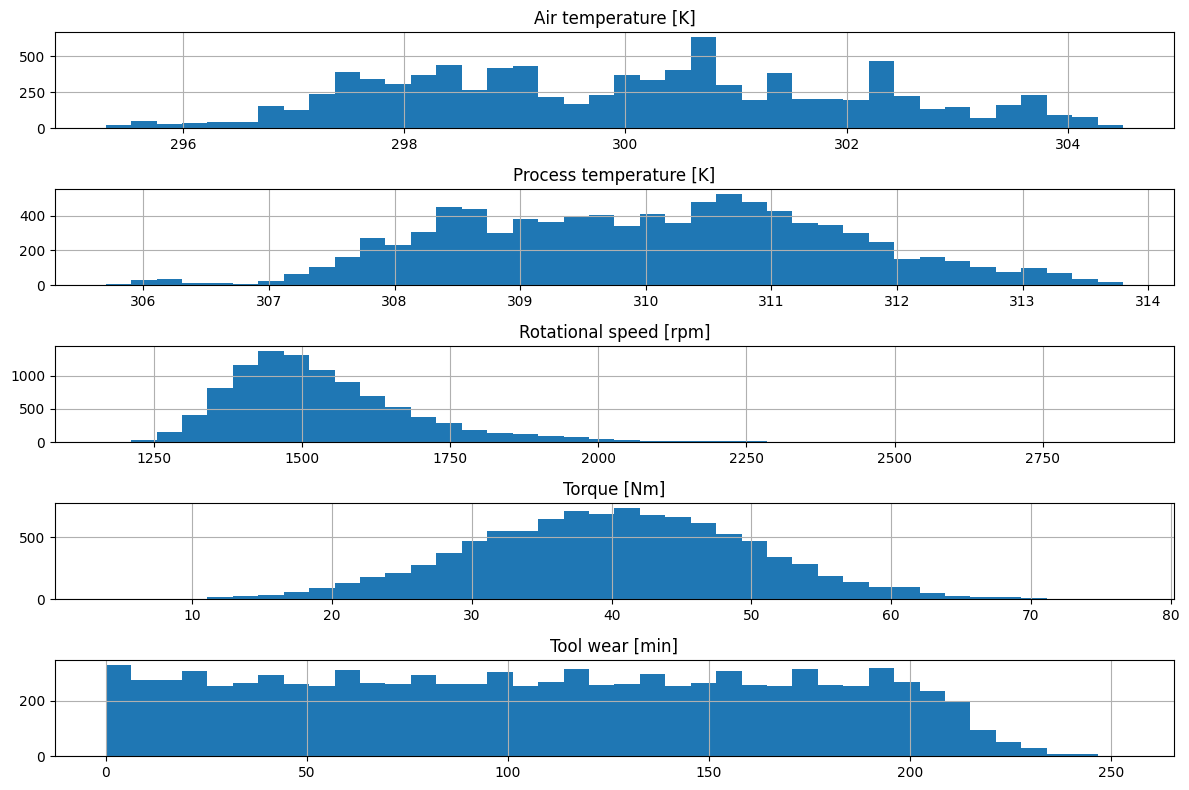

In [5]:
from plotterclass import Plotter ##Importing the plotter class
    

# Instance of the Plotter class
plotter = Plotter()

plotter.hist_plotter(df)

Working for data imputation:

- Data set of moderate size and columns displaying null percentage rates of <10, therefore imputation is the correct method to use. 

- D’Agostino’s K^2 Test and histogram plots suggest that the data is normally distributed
- Q-q plots suggest normal distribution (at least through the middle of the range)
- Therefore we can infer that the data in normally distributed and the values are missing at random
- Therefore mean value used to impute the missing null values

## Imputing the null values from the Dataframe based on the workings above

In [6]:
from dataframetransformclass import DataFrameTransform ##Importing the class that performs dataframe transformations

dftransformer = DataFrameTransform() ##An instance of the dataframe transformer class
df_imputed = dftransformer.impute_nulls_mean(df) ##New dataframe with the nulls imputed

imputed_df_info = DataFrameInfo(df_imputed)

print("\nNull value counts and percentages after imputation:")
print(imputed_df_info.count_nulls())



Null value counts and percentages after imputation:
                         null_count  null_percentage
UDI                               0              0.0
Product ID                        0              0.0
Type                              0              0.0
Air temperature [K]               0              0.0
Process temperature [K]           0              0.0
Rotational speed [rpm]            0              0.0
Torque [Nm]                       0              0.0
Tool wear [min]                   0              0.0
Machine failure                   0              0.0
TWF                               0              0.0
HDF                               0              0.0
PWF                               0              0.0
OSF                               0              0.0
RNF                               0              0.0


/Users/joe/Documents/AiCore/VS Code/DataAnalysisProject/dataframetransformclass.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(col_mean, inplace=True)


From the new Null % counts we can see the data has been successfully imputed!

In [7]:
skew_results = df_imputed[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].skew()

print(skew_results)

Air temperature [K]        0.123842
Process temperature [K]    0.006837
Rotational speed [rpm]     1.993171
Torque [Nm]               -0.009517
Tool wear [min]            0.021715
dtype: float64


As this is a fairly large Dataset (10,000), I will only correct the skew of the columns that are > 1 and < -1. This indicates that Rotational speed is the only column that needs transforming to correct the skew. From looking at the histograms it is clear to see that this column has a clear positive (right) skew. The others do not exhibit such skews and look relatively symmetrical. Air temperature exhibits the next largest skew, but as this dataset is large I do not believe it needs transforming. 

I will start by performing a log transformation to see if it corrects the skew. I will create the method in the DataFrameTransform class as requested. 

The correction after the log transformation:


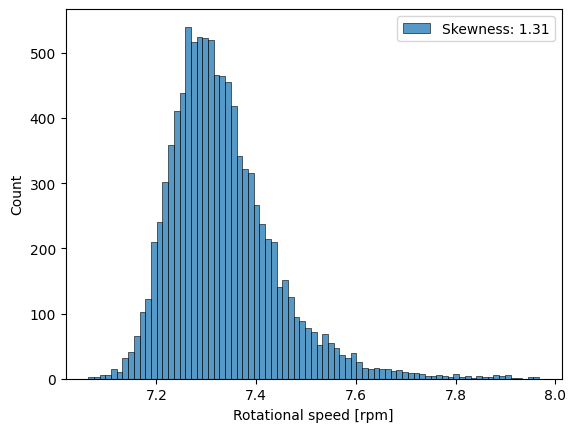

The correction after the Box-Cox transformation:


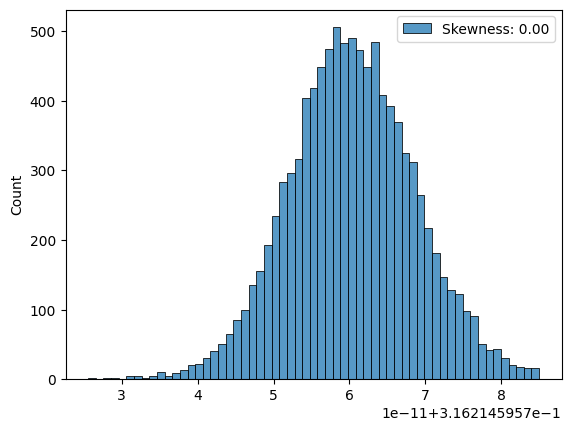

In [8]:
plotter.test_log(df_imputed) 

print("The correction after the log transformation:")
plt.show() 

plotter.test_boxcox(df_imputed) 

print("The correction after the Box-Cox transformation:")
plt.show() 

The above figures show that the a Box-Cox transformation corrects the skewed data to the least amount of skewness, therefore I will use this transformation on the data. These methods used so far only show the theorised skew-correction, to correct the scew and replace the data in the dataframe I will use the correct_skew_boxcox method to make the changes permanent:

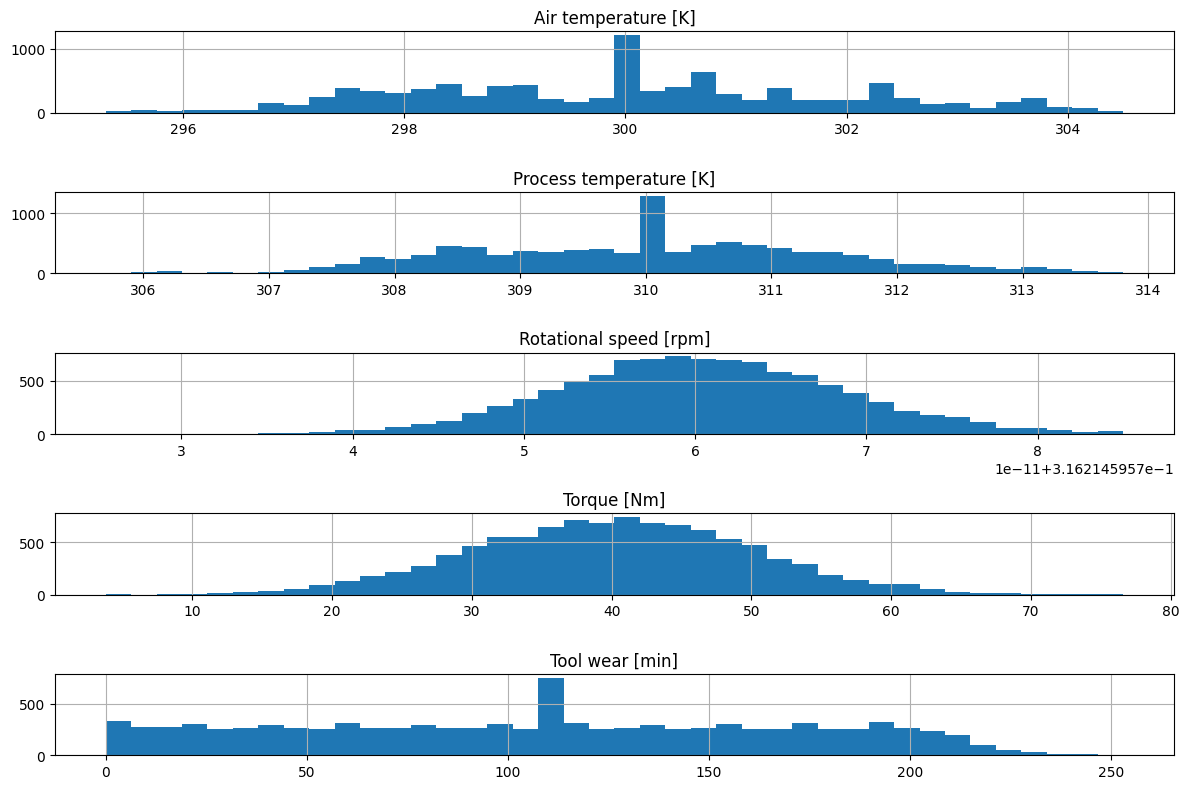

In [9]:
df_transformed = dftransformer.correct_skew_boxcox(df_imputed) # Call the class method using the transformer instance of the class, creating a new dataframe from the null-imputed dataframe, which now contains the transformed rotational speed values

plotter.hist_plotter(df_transformed)

As we can see, the data-skew has been corrected

# Dealing with outliers

## Starting with visual methods. 

Using the plotter class methods for creating histograms and boxplots to check for outliers:

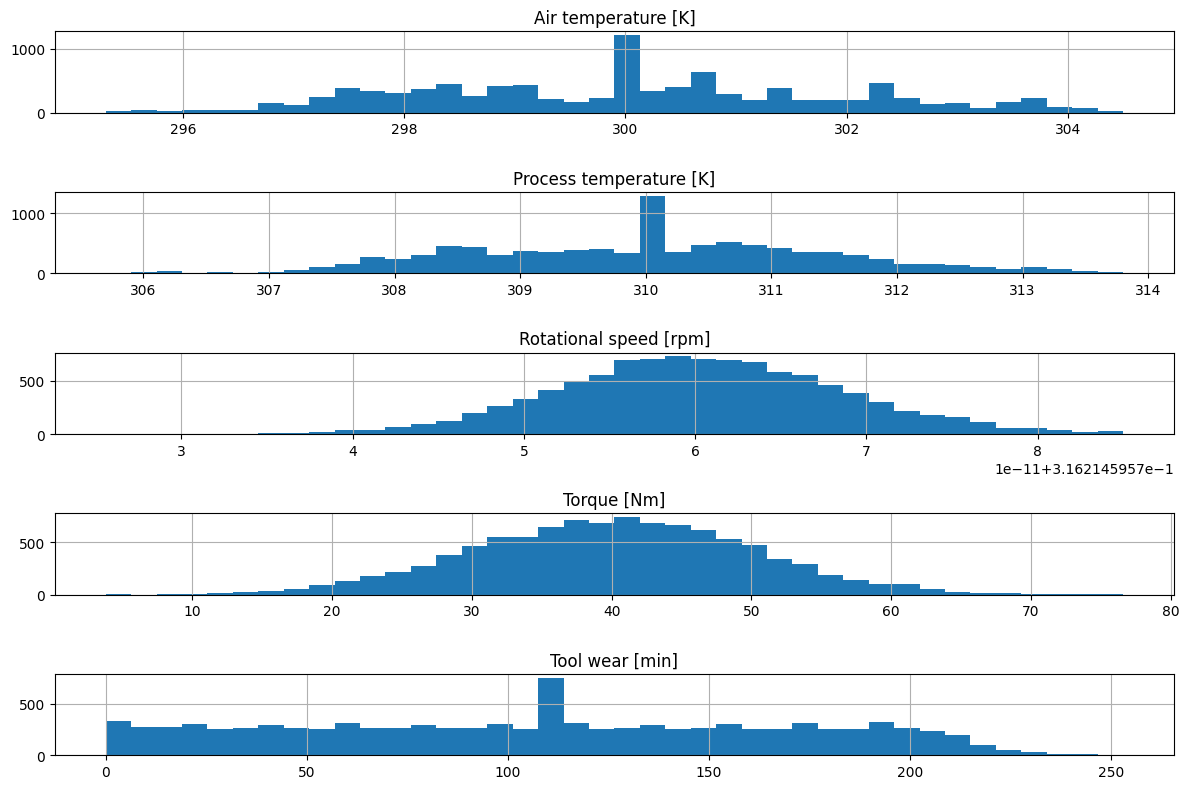

In [10]:
plotter.hist_plotter(df_transformed)

plotter.box_plot_outlier_check(df_transformed)

From boxplots and histograms the columns Rotational speed [rpm] and Torque [Nm] appear to be normally distributed.

The columns Air temperature [K], Process temperature [K] and Tool wear [min] do not appear to be normally distributed. 

Next we look at statistical methods for outlier dection:

For normally distributed data, z score is an effective way of identigying outliers. From the histograms there appears to be some outliers in the tails of the graphs.  
  
    The Z-Score is a statistical measurement that describes a data point's position relative to the mean of a group of values, measured in terms of standard deviations. Data points with a Z-Score having a high absolute value, typically beyond a threshold like 2 or 3, are often considered outliers as they significantly deviate from the average.

Below shows the highest and lowest values of z score for each of the normally distributed columns.

In [11]:
df_transformed_z = dftransformer.z_scores(df_transformed)

print('\nLowest z score values for Rotational speed:')
print(df_transformed_z['Rotational speed [rpm]_zscore'].sort_values().head())
print('\nHighest z score values for Rotational speed:')
print(df_transformed_z['Rotational speed [rpm]_zscore'].sort_values().tail())

print('\nLowest z score values for Torque:')
print(df_transformed_z['Torque [Nm]_zscore'].sort_values().head())
print('\nHighest z score values for Torque:')
print(df_transformed_z['Torque [Nm]_zscore'].sort_values().tail())


Lowest z score values for Rotational speed:
2913   -4.206877
4048   -3.944500
9874   -3.905194
6979   -3.731690
404    -3.581984
Name: Rotational speed [rpm]_zscore, dtype: float64

Highest z score values for Rotational speed:
374     2.953805
3610    2.957964
3342    2.972141
4012    2.978524
1517    2.984316
Name: Rotational speed [rpm]_zscore, dtype: float64

Lowest z score values for Torque:
1517   -3.630149
4012   -3.590023
3342   -3.549896
3610   -3.449580
374    -3.429516
Name: Torque [Nm]_zscore, dtype: float64

Highest z score values for Torque:
3645    3.371952
433     3.462237
4833    3.552522
6092    3.632776
404     3.672902
Name: Torque [Nm]_zscore, dtype: float64


### Considering the results above.

As can be seen, all columns present z scores in the range of 2 to 3. This indicates deviation from the average. However, these z scores are accompanied by similarly high-absolute-value z scores, and none stand out, even for rotational speed which contains values above 7 (to be expected since we have already seen the data is positively skewed for this column pre-transformation). Therefore I propose that these data are real and useful and should not be removed. If, for example, there was a z score with an absolute value that was signifcantly different to the rest, indicating a true outlier, I would propose removal of this data point. 

Creating a dataframe where all rows containing a z score above 3 or below 3 are removed (for all columns where the data is normally distributed):

In [12]:
df_concat = dftransformer.z_scores(df_transformed_z)

## creating a cleaned dataframe based on the criteria in the markdown above.

df_cleaned = dftransformer.clean_z_score_outliers(df_concat)

print(df_cleaned.count()) ## A count of values in each column, showing 48 rows have been removed 

UDI                              9952
Product ID                       9952
Type                             9952
Air temperature [K]              9952
Process temperature [K]          9952
Rotational speed [rpm]           9952
Torque [Nm]                      9952
Tool wear [min]                  9952
Machine failure                  9952
TWF                              9952
HDF                              9952
PWF                              9952
OSF                              9952
RNF                              9952
Torque [Nm]_zscore               9952
Rotational speed [rpm]_zscore    9952
dtype: int64


It can now be seen that in the resulting cleaned dataframe 48 values have been dropped as outliers from the columns Rotational Speed and Torque.

This represents a 0.48% loss in data, which is an acceptable amount. 

### For the columns not normally distributed:

Using the Inter Quartile Range (IQR) to identify any values that lie outside of the common range of variability is a better method to use for data of this type.

    The Interquartile Range (IQR) is a statistical measure that represents the range between the first quartile (25th percentile) and the third quartile (75th percentile) of a dataset. Values that fall below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR are typically classified as outliers, as they lie outside the common range of variability in the data.

For this we can use the remove_outliers_iqr function from dataframetransformclass.


In [13]:
df_cleaned_new = dftransformer.remove_outliers_iqr(df_cleaned)

print(df_cleaned_new.count())

UDI                              9942
Product ID                       9942
Type                             9942
Air temperature [K]              9942
Process temperature [K]          9942
Rotational speed [rpm]           9942
Torque [Nm]                      9942
Tool wear [min]                  9942
Machine failure                  9942
TWF                              9942
HDF                              9942
PWF                              9942
OSF                              9942
RNF                              9942
Torque [Nm]_zscore               9942
Rotational speed [rpm]_zscore    9942
dtype: int64


We can see that using this method, an additional 10 values have been removed. Therefore the total data loss is now 0.58%. 

## Dropping overly correlated columns

In [14]:
selected_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

px.imshow(df_cleaned_new[selected_columns].corr(), title="Correlation heatmap of failure data")

This shows the correlation matrix for the numerical columns in the dataframe. From this matrix it appears that Air temperature and Proess temperature are the most correlated columns. However, with the correlation value under 0.8, I would not be confident in dropping either of these values.

There is also a more powerful method of calculating the correlation between variables, called the variation inflation factor or VIF. This method is more powerful as we fit a linear regression model on one of our independent variables against all the other exogenous variables. Usually, if the VIF value is above 10 we can consider the variable being adequately explained by our other variables, and it would be a valid assumption to drop that variable.

In [ ]:
plotter.calculate_vif(df_cleaned_new) ##Calling the caluculate VIF class method from the plotter class to calculate the VIF of the variables.

/opt/homebrew/Caskroom/miniconda/base/envs/Test_Env1/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide



,Variable,VIF
1,Air temperature [K],2.742180
2,Process temperature [K],2.741152
3,Rotational speed [rpm],6.275676
4,Torque [Nm],6.274778
5,Tool wear [min],1.000310


As can be seen, no variable exhibits a VIF of over 10, so we can make the inference not to drop any of the variables based on this metric. 